This notebook applies a random forest classifier to classify Alzheimer's disease from anatomical MRI images using a low-dimensional feature space. Key steps include data formatting and quality checks, feature extraction and visualization, and permutation testing for statistical significance using parallel processing. It also explores feature importance and interpretation.

In [0]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.stats import false_discovery_control

# Parallel computing
import dask
from dask.distributed import Client, progress

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2, pickle 
import magic
from IPython.display import clear_output

import sys
sys.path.append('/Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/src')
from random_forest_permute import classification_RF_shuffle, iteration_permute

clear_output(wait=False)

Mount AWS S3 bucket containing processed data

In [0]:

AWS_S3_BUCKET = "databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/"
KEY_FILE = "/FileStore/tables/brad_databricks_personal_accessKeys_new.csv"

# extract aws credentials from hidden table 
aws_keys_df = spark.read.format("csv").option("header", "true").option("sep", ",").load(KEY_FILE)

ACCESS_KEY = aws_keys_df.collect()[0][0]
SECRET_KEY = aws_keys_df.collect()[0][1]

# specify bucket and mount point
MOUNT_NAME = f"/mnt/{AWS_S3_BUCKET.split('/')[-2]}"
SOURCE_URL = f"s3a://{AWS_S3_BUCKET}"
EXTRA_CONFIGS = { "fs.s3a.access.key": ACCESS_KEY, "fs.s3a.secret.key": SECRET_KEY}

# mount bucket
if any(mount.mountPoint == MOUNT_NAME for mount in dbutils.fs.mounts()):
    print(f"{MOUNT_NAME} is already mounted.")
else:
    dbutils.fs.mount(SOURCE_URL, MOUNT_NAME, extra_configs = EXTRA_CONFIGS)
    print(f"{MOUNT_NAME} is now mounted.")

/mnt/AD_MRI_classification is already mounted.


In [0]:
# Load data file and unpack contents
s3_file_path = 'AD_MRI_classification/preprocessed/data_pre.pkl'
file_path = f"/dbfs/mnt/{s3_file_path}"

with open(file_path, 'rb') as f:
    train_data, train_lab, test_data, test_lab = pickle.load(f)

Lab = ['Mild', 'Moderate', 'None', 'Very Mild']

Decompose data with PCA

In [0]:
train_data_pca = []
for i in range(len(train_data)):
    train_data_pca.append(np.reshape(train_data[i], (1, -1)))    
train_data_pca = np.vstack(train_data_pca[:])

# decompose with PCA and look at various metrics/info
num_comp = 50
pca = PCA(n_components = num_comp)
pca.fit(train_data_pca)

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

PCA(n_components=50)

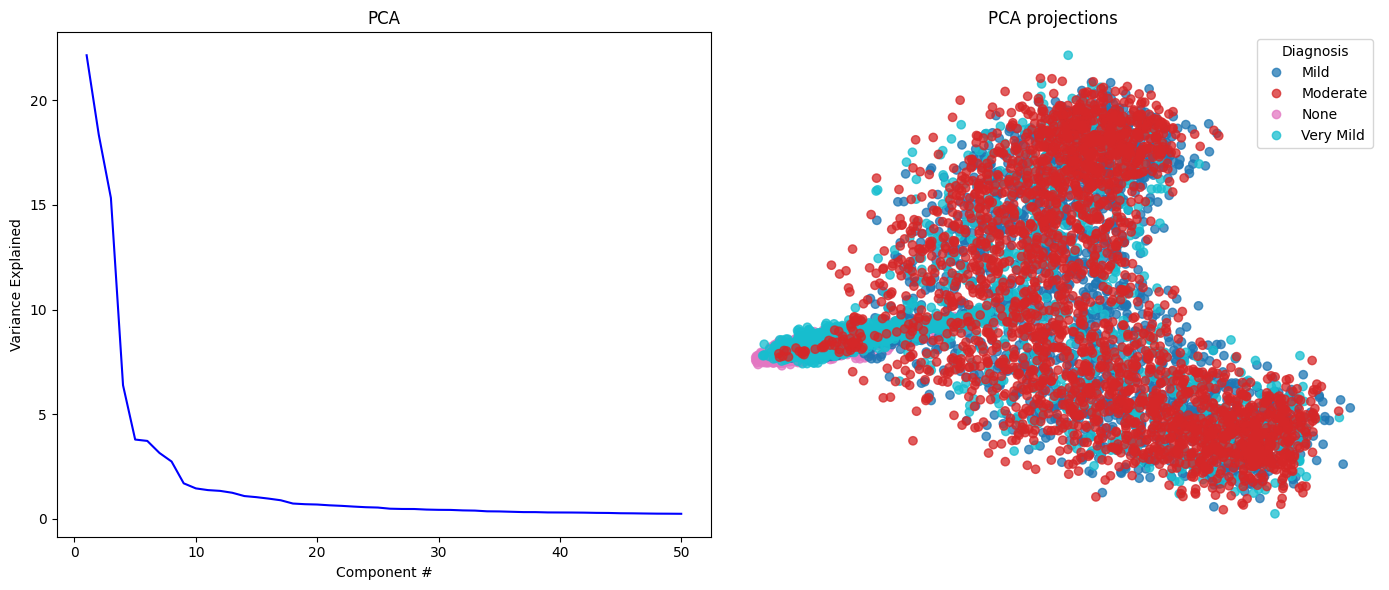

In [0]:
# project data on first two PC's
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
load_train = np.matmul(train_data_pca, loadings[:,:2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot variance explained
ax1.plot(np.linspace(1, num_comp, num_comp), pca.explained_variance_[:num_comp] / sum(pca.explained_variance_[:num_comp]) * 100, 'b')
ax1.set_title('PCA')
ax1.set_xlabel('Component #')
ax1.set_ylabel('Variance Explained')

# Plot first two PCs
s = ax2.scatter(load_train[:, 0], load_train[:, 1], c=train_lab * 2, cmap='tab10', alpha=0.75)
handles, labels = s.legend_elements()
legend = ax2.legend(handles=handles, labels=Lab, title='Diagnosis', loc='upper right')
ax2.axis('off')
ax2.set_title('PCA projections')
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')

plt.tight_layout()
plt.show()

Apply random forest classifier to first two PCs

In [0]:
# Train random forest classifier on first two PCs and apply to test data
rf = RandomForestClassifier()

# Train classifier
load_train = np.matmul(train_data_pca, loadings[:,:2])
rf.fit(load_train, train_lab)

# Properly format test data and extract same features (PC loadings)
test_data_pca = []
for i in range(len(test_data)):
    test_data_pca.append(np.reshape(test_data[i], (1, -1)))    
test_data_pca = np.vstack(test_data_pca[:])

# Test data in PC space
load_test = np.matmul(test_data_pca, loadings[:,:2])

# Predict unseen testdata
predictions = rf.predict(load_test)


Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Overall classification accuracy is: 46.40625 %


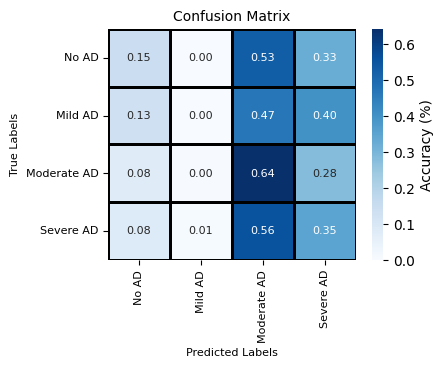

In [0]:
# compare predictions with test labels and compute accuracy
result = predictions - test_lab
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary,0)
acc = correct/test_lab.shape[0]*100
print(f"Overall classification accuracy is: {acc} %")

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(test_lab, predictions)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(4, 3))

sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Accuracy (%)'}, 
            xticklabels=['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'], 
            yticklabels=['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'], 
            ax=ax, linewidths=1, linecolor='black', annot_kws={"size": 8})
ax.set_xlabel('Predicted Labels', fontsize=8)
ax.set_ylabel('True Labels', fontsize=8)
ax.set_title('Confusion Matrix', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=8)

When using the top two PCs, we see a modest classification rate on the test set. However, there is a clear bias here towards the Moderate AD class, which had the largest "original" dataset.

Furthermore, using two PC's  is arbitrary and is easy simply due to visualization purposes. We can also examine accuracy as a function of the number of PCs, and visualize the PC loading maps to interpret the classification results. But first, let's run some statistics to determine if the classification is significant in its current state.

Permutation testing on shuffled data as a control

In [0]:
# Parallelize time-consuming iterative processes with Dask (local)
client = Client(threads_per_worker = 4, n_workers = 1)
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:42577
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36259'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:43415 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43415
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:44556
INFO:distributed.scheduler:Receive client connection: Client-41a2b29d-cda2-11ef-9cc3-00163ee346c0
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:44566


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 3.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42577,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.85 GiB
Comm: tcp://127.0.0.1:43415,Total threads: 4
Dashboard: http://127.0.0.1:44097/status,Memory: 3.85 GiB
Nanny: tcp://127.0.0.1:36259,


Shuffle data labels in the training set when building RF classifier. We do this hundred

In [0]:
train_lab_shuffle = train_lab
load_train = np.matmul(train_data_pca, loadings[:,:2])

acc_shuffle = iteration_permute(load_train, train_lab_shuffle, load_test, test_lab)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

## Permute a sufficient number of times (here 500)

### Not the most efficient way to do this, but must consider memory on local machine

In [0]:
%%time

acc_shuffle_compile = []
for i in range(5):
    acc_tmp = iteration_permute(load_train, train_lab_shuffle, load_test, test_lab)
    acc_shuffle_compile = np.concatenate((acc_shuffle_compile, acc_tmp), axis=0)

b = plt.boxplot(acc_shuffle_compile)
plt.title('Shuffled Classification Accuracy')
plt.xlabel('Shuffled')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 60)

## Side note: validate parallel processing by comparing computation against serial processing

In [0]:
%%time

# simple test to ensure that parallel processing is faster

# traditional for loop
acc_shuffle_nodask = []
for i in range(100):
    acc_tmp = classification_RF_shuffle(load_train, train_lab_idx, load_test, test_lab_idx)
    acc_shuffle_nodask.append(acc_tmp)

In [0]:
%%time

# dask parallelization
acc_shuffle_dask = []
for i in range(1):
    acc_tmp = iteration_permute(load_train, train_lab_idx_shuffle, load_test, test_lab_idx)
    acc_shuffle_dask = np.concatenate((acc_shuffle_dask, acc_tmp), axis=0)
    clear_output(wait = True)

#### We can in fact see that parallelization with dask does markedly reduce the computation time (on the CPU). Of course, IO data transfer is the bottleneck here, but this will reduce computation time enough for this example on a Jupyter Notebook.

## Determine significance of classification accuracy (permutation test)

In [0]:
null_above_value = (acc_shuffle_compile > acc).sum()
p_value = null_above_value/np.size(acc_shuffle_compile,0)
print(p_value)

# We can see here that the classification accuracy is not sigificcantly different from chance with p-value > 0.05

## Now explore RF classification as a function of PCs

In [0]:
def classification_RF_PCs(train_data, train_lab_idx, test_data, test_lab_idx, loadings, num_pc):

    load_train = np.matmul(train_data, loadings[:,:num_pc])
    
    rf_1 = RandomForestClassifier()
    rf_1.fit(load_train, train_lab_idx)
    
    load_test = np.matmul(test_data, loadings[:,:num_pc])
    
    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)
    
    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    return acc

def iteration_PCs(train_data, train_lab_idx, test_data, test_lab_idx, loadings, pc_idx):
    
    acc_PC = []
    for i in pc_idx:
        acc_tmp = dask.delayed(classification_RF_PCs)(train_data, train_lab_idx, test_data, test_lab_idx, loadings, i)
        acc_PC.append(acc_tmp)
    
    # compute values
    acc_PC = dask.compute(*acc_PC)
    clear_output(wait = True)
    acc_PC = np.array([float(num) for num in acc_PC])
    return acc_PC

### Batch parallel processing to conserve memory

In [0]:
%%time

idx = [np.linspace(1,50,50, dtype = 'int'), np.linspace(51,100,50, dtype = 'int')]

acc_PC_compile = []
for i in range(len(idx)):
    
    acc_tmp = iteration_PCs(train_data, train_lab_idx, test_data, test_lab_idx, loadings, idx[i])
    acc_PC_compile = np.concatenate((acc_PC_compile, acc_tmp), axis = 0)

# plot accuracy as a function of PCs
plt.plot(np.linspace(1,np.size(acc_PC_compile,0), np.size(acc_PC_compile,0)), acc_PC_compile, 'k')
plt.title('Classification accuracy')
plt.xlabel('# of PCs included')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 100)
plt.xlim(-5, 105)

## Permutation testing for each number of PCs

In [0]:
def classification_RF_shuffle_PCs(train_data, train_lab_idx_shuffle, test_data, test_lab_idx, loadings, num_pc):

    load_train = np.matmul(train_data, loadings[:,:num_pc])
    
    rf_1 = RandomForestClassifier()
    rng.shuffle(train_lab_idx_shuffle)
    rf_1.fit(load_train, train_lab_idx_shuffle)
    
    load_test = np.matmul(test_data, loadings[:,:num_pc])
    
    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)
    
    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    return acc

def iteration_permute_PCs(train_data, train_lab_idx_shuffle, test_data, test_lab_idx, loadings, num_pc):
    
    acc_shuffle = []
    for i in range(100):
        acc_tmp = dask.delayed(classification_RF_shuffle_PCs)(train_data, train_lab_idx_shuffle, test_data, test_lab_idx, loadings, num_pc)
        acc_shuffle.append(acc_tmp)
    
    # compute values
    acc_shuffle = dask.compute(*acc_shuffle)
    acc_shuffle = np.array([float(num) for num in acc_shuffle])
    clear_output(wait = True)
    return acc_shuffle

# def iteration_shuffle_PCs(train_data, train_lab_idx, test_data, test_lab_idx, loadings, pc_idx):
    
#     acc_PC = []
#     for i in pc_idx:
#         acc_tmp = dask.delayed(iteration_permute_PCs)(train_data, train_lab_idx_shuffle, test_data, test_lab_idx, loadings, i)
#         acc_PC.append(acc_tmp)
    
#     # compute values
#     acc_PC = dask.compute(*acc_PC)
#     clear_output(wait = True)
#     # acc_PC = np.array([float(num) for num in acc_PC])
#     return acc_PC

In [0]:
%%time

idx = np.linspace(1,100,100, dtype = 'int')
acc_shuffle_PC_compile = []
for i in idx:
    acc_tmp = iteration_permute_PCs(train_data, train_lab_idx_shuffle, test_data, test_lab_idx, loadings, i)
    acc_shuffle_PC_compile.append(acc_tmp)


## Compare classification accuracy to chance level for each number of PCs

In [0]:
# plot accuracy as a function of PCs

# accuracy as a function of PCs
plt.plot(np.linspace(1,np.size(acc_PC_compile,0), np.size(acc_PC_compile,0)), acc_PC_compile, 'k')

# corresponding chance level
p_value_compile = []
for i in range(len(acc_shuffle_PC_compile)):
    b = plt.boxplot(acc_shuffle_PC_compile[i], 'b', positions = [i+1], flierprops = {'marker': '.', 'markersize': 5})

    # permutation testing
    null_above_value = (acc_shuffle_PC_compile[i] > acc_PC_compile[i]).sum()
    p_value_compile.append(null_above_value/np.size(acc_shuffle_PC_compile[i],0))

# visualize statistical results
p_value_compile = np.array([float(num) for num in p_value_compile])
p_value_adj = false_discovery_control(p_value_compile)   

for i in range(len(p_value_adj)): 
    if p_value_adj[i] < 0.05:
        plt.scatter(i, 95, s = 10, c = 'r', marker = "*")

plt.title('Classification accuracy')
plt.xlabel('# of PCs included')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 100)
plt.xlim(-5, 105)
p_value_compile

## Feature interpretation

### Visualize spatial PC maps to identify features that contribute to data variance and classification

In [0]:
f, ax = plt.subplots(5,4)
lim = 20
for ipc in range(lim):

    PC_map = loadings[:,ipc]
    PC_map = np.reshape(PC_map, (128,128))
    clim = max(abs(np.min(PC_map)), abs(np.max(PC_map)))

    idx1 = np.floor(ipc/4).astype(int)
    idx2 = np.fmod(ipc,4)
    ax[idx1, idx2].axis('off')
    ax[idx1, idx2].imshow(PC_map, cmap = "magma", vmin = -clim, vmax = clim)
    ax[idx1, idx2].set_title(f'PC# {ipc +1}', fontsize = 10)
    plt.tight_layout()

#### Here we can see that for each of the top 20 PC's there are brain regions are more strongly weighted than others (in either the positive or negative direction). It is important to note that it does not appear that each image used in this dataset came from the same location/slice within the brain. We do not know if certain slices are over- or under-represented in different AD classes and therefore cannot say with certainty whether specific anatomical structures drive different stages of AD. Nevertheless,